In [ ]:
!pip install datasets transformers torch evaluate

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_dir = r"/content/drive/MyDrive/Scanning Electron Microscopy Imaging of Nanoparticles/stutcure"

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing the images to 224x224
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

In [ ]:
train_dataset = datasets.ImageFolder(root=base_dir, transform=transform)

# batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

from torch.utils.data import random_split

train_size = int(0.8 * len(train_dataset))  # 80% for training
test_size = len(train_dataset) - train_size  # Remaining 20% for testing

# Split the dataset into training and testing sets
train_subset, test_subset = random_split(train_dataset, [train_size, test_size])

# Create DataLoaders for training and testing
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

In [ ]:
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Class names: {train_dataset.classes}")

Number of classes: 6
Class names: ['Non Structure', 'bright', 'circle', 'lone', 'sheet bends', 'sheet borders']


In [ ]:
from transformers import ViTFeatureExtractor
model_id = 'google/vit-base-patch16-224-in21k'
FeatureExtractor = ViTFeatureExtractor.from_pretrained(model_id)


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
def collate_fn(batch):
    pixel_values = torch.stack([item[0] for item in batch])  # Extract pixel values
    labels = torch.tensor([item[1] for item in batch])       # Extract labels
    return {"pixel_values": pixel_values, "labels": labels}



In [ ]:
import numpy as np
import evaluate

# Load the accuracy metric using the evaluate library
metric = evaluate.load("accuracy")

# Define the compute_metrics function
def compute_metrics(p):
    return metric.compute(
        predictions=np.argmax(p.predictions, axis=1),
        references=p.label_ids
    )


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./ntu_sem",
  per_device_train_batch_size=32,
  evaluation_strategy="steps",
  num_train_epochs=10,
  save_steps=100,
  eval_steps=50,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  load_best_model_at_end=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import ViTForImageClassification


model = ViTForImageClassification.from_pretrained(
    model_id,  # classification head
    num_labels=6
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
from transformers import Trainer
from accelerate import Accelerator

accelerator = Accelerator()

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_subset,
    eval_dataset=test_subset,
    tokenizer=FeatureExtractor,
)


<ipython-input-88-d574cf252579>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
train_results = trainer.train()
# save tokenizer with the model
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
# save the trainer state
trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy
50,0.342400,0.674703,0.813333
100,0.141200,0.513270,0.840000
150,0.072400,0.637060,0.813333


***** train metrics *****
  epoch                    =        10.0
  total_flos               = 433035759GF
  train_loss               =      0.2278
  train_runtime            =  0:05:23.78
  train_samples_per_second =      18.531
  train_steps_per_second   =       0.587


In [ ]:
outputs = trainer.predict(test_subset)
print(outputs.metrics)

{'test_loss': 0.5132696628570557, 'test_accuracy': 0.84, 'test_runtime': 3.7302, 'test_samples_per_second': 40.212, 'test_steps_per_second': 5.094}


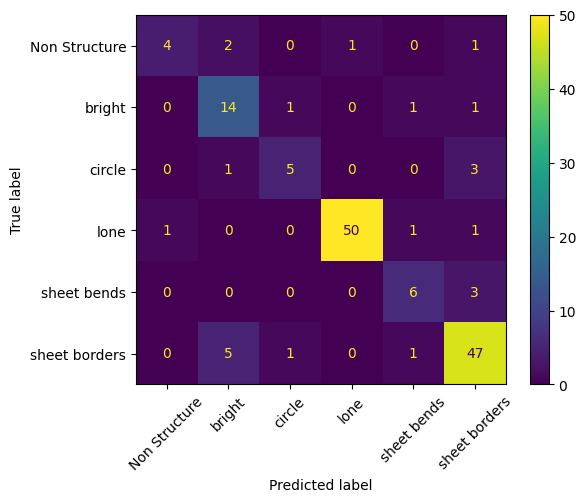

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_subset.dataset.classes
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)